# Import

In [150]:
# import everything 

import os
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snowflake.connector as snow
from prophet import Prophet

# Get Data

In [170]:
# write function to get data from snowflake

def query_snowflake(sql_query):
    '''Runs the supplied query and returns a Pandas dataframe.'''
    
    ctx = snow.connect( 
        account       = 'acs.us-east-1',
        user          = 'ankur.vishwakarma@autodesk.com',
        authenticator = 'externalbrowser',
        warehouse     = 'BC_TRANSFORM',
        role          = 'PG_INSIGHTS_ROLE'
    )

    cs = ctx.cursor()

    try:
        cs.execute(sql_query)
        data = pd.DataFrame(cs.fetchall())
        data.columns = [x[0] for x in cs.description]
    finally:
        cs.close()

    ctx.close()
    
    return data

In [214]:
# get data from Snowflake

sql_query = '''
with
calendar as (
    select * from analytics_dev.dbt_ankur_acs.dim_calendar
),

date_spine as (  
    select distinct date_trunc('week', date::date) as dt_week
    from calendar
    where dt_week >= '2020-01-01'
    and dt_week <= '2021-12-31'
),

mqlas as (
    select 
        date_trunc('week', first_responded_date)::date as dt, 
        count(distinct email) as mqla
    from analytics.dw.marketing_key_metrics_master
    where mqla_c = TRUE
    and dt < date_trunc('week', current_date)
    group by 1 
    order by 1
)

select 
    date_spine.*, 
    mqlas.*, 
    calendar.quarter_adsk_text,
    calendar.quarter_adsk_text_long,
    rank() over (partition by quarter_adsk_text_long order by dt_week desc) as weeks_until_quarter_end
from date_spine 
left join mqlas on date_spine.dt_week = mqlas.dt
left join calendar on date_spine.dt_week = calendar.date::date
order by dt_week
;'''

df = query_snowflake(sql_query)

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.4.2, Python Version: 3.8.5, Platform: macOS-10.16-x86_64-i386-64bit
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.cursor:query: [with calendar as ( select * from analytics_dev.dbt_ankur_acs.dim_calendar ),  da...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data done
INFO:snowflake.connector.connection:closed
INFO:snowflake.connector.connection:No async queries seem to be running, deleting session


In [255]:
sql_daily = '''
with
calendar as (
    select * from analytics_dev.dbt_ankur_acs.dim_calendar
),

date_spine as (  
    select 
        date::date as dt,
        calendar.quarter_adsk_text,
        calendar.quarter_adsk_text_long,
        rank() over (partition by quarter_adsk_text_long order by dt desc) as days_until_quarter_end
    from calendar
    where dt >= '2020-01-01'
    and dt <= '2021-12-31'
),

mqlas as (
    select 
        date_trunc('day', first_responded_date)::date as dt, 
        count(distinct email) as mqla
    from analytics.dw.marketing_key_metrics_master
    where mqla_c = TRUE
    and dt < current_date()
    group by 1 
    order by 1
)

select 
    date_spine.dt, 
    mqla, 
    quarter_adsk_text,
    quarter_adsk_text_long,
    days_until_quarter_end
from date_spine 
left join mqlas on date_spine.dt = mqlas.dt
order by date_spine.dt
;'''

df = query_snowflake(sql_daily)

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.4.2, Python Version: 3.8.5, Platform: macOS-10.16-x86_64-i386-64bit
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.cursor:query: [with calendar as ( select * from analytics_dev.dbt_ankur_acs.dim_calendar ),  da...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data done
INFO:snowflake.connector.connection:closed
INFO:snowflake.connector.connection:No async queries seem to be running, deleting session


# Data Analysis

In [256]:
def lower_column_names(dataframe):
    
    temp_df_cols = dataframe.columns.tolist()
    df_cols = dict()

    for c in temp_df_cols:
        df_cols[c] = c.lower()

    new_dataframe = dataframe.rename(columns = df_cols)
    
    return new_dataframe

In [257]:
# correct for outliers and lower column names

df = lower_column_names(df)
df['mqla'] = df['mqla'].apply(lambda x: 10000 if x>10000 else x)

In [240]:
# add columns and goals

df['dt'] = pd.to_datetime(df['dt'])
df['value_type'] = df['mqla'].apply(lambda x: 'actual' if np.isnan(x)==False else np.nan)
df['last_day_in_quarter'] = df['days_until_quarter_end'].apply(lambda x: 1 if x==1 else 0)

quarterly_mqla_goal = 150000
daily_mqla_goal = round(quarterly_mqla_goal/(365/4))

df['daily_mqla_goal'] = daily_mqla_goal
df['quarterly_mqla_goal'] = df['last_day_in_quarter'].apply(lambda x: quarterly_mqla_goal if x==1 else 0)

In [243]:
df.head()

,dt,mqla,quarter_adsk_text,quarter_adsk_text_long,days_until_quarter_end,value_type,last_day_in_quarter,daily_mqla_goal,quarterly_mqla_goal
0,2020-01-01,566.0,Q4,Q4-2020,31,actual,0,1644,0
1,2020-01-02,2083.0,Q4,Q4-2020,30,actual,0,1644,0
2,2020-01-03,1232.0,Q4,Q4-2020,29,actual,0,1644,0
3,2020-01-04,574.0,Q4,Q4-2020,28,actual,0,1644,0
4,2020-01-05,634.0,Q4,Q4-2020,27,actual,0,1644,0


# Forecast

In [220]:
train = df[['dt', 'mqla']].dropna()
train.rename(columns = {'dt':'ds', 'mqla':'y'}, inplace = True)

In [221]:
# train prophet

m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [222]:
future = m.make_future_dataframe(periods = 100)
forecast = m.predict(future)

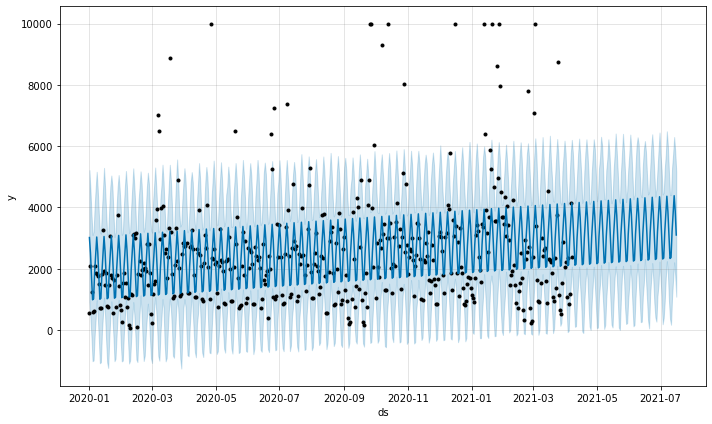

In [223]:
fig1 = m.plot(forecast)

In [244]:
combined = pd.merge(df, forecast[['ds', 'yhat']], how = 'left', left_on = 'dt', right_on = 'ds')

In [245]:
combined['value_type'].fillna('forecast', inplace = True)
combined['mqla'].fillna(combined['yhat'], inplace = True)

combined.drop(columns = ['ds', 'yhat'], inplace = True)
combined.loc[461:465]

,dt,mqla,quarter_adsk_text,quarter_adsk_text_long,days_until_quarter_end,value_type,last_day_in_quarter,daily_mqla_goal,quarterly_mqla_goal
461,2021-04-06,4131.000000,Q1,Q1-2022,25,actual,0,1644,0
462,2021-04-07,2382.000000,Q1,Q1-2022,24,actual,0,1644,0
463,2021-04-08,3647.076923,Q1,Q1-2022,23,forecast,0,1644,0
464,2021-04-09,2863.026542,Q1,Q1-2022,22,forecast,0,1644,0
465,2021-04-10,2114.475812,Q1,Q1-2022,21,forecast,0,1644,0


In [250]:
combined.to_csv('mqla_forecast_test.csv')